<a href="https://colab.research.google.com/github/Manuel-FA/Deep_Learning/blob/main/Car%20Object%20Detection%20-%20Dataset_1%20-%20Beginner.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <font color="#000080B">**ABSTRACT**</font>

*  A neural network was used that allows detecting cars, a precision of 0.9894 was obtained. It served to understand the management of bounding boxes and how to build a model of several different layers of a neural network.
*   Model: Neural network from Keras
*   Libraries used: Numpy, Pandas, MatPlotLib, Tensorflow, Keras and OpenCV

# <font color="#000080B">**1. Introduction**</font>
---


## <font color="#000080B">**1.1. Content**</font>


    1. Introduction
      1.1. Content
      1.2. Problem statement
    2. Project preparation
      2.1. Libraries import
      2.2. Data import
    3. Exploratory data analysis
    4. Modeling
      4.1. Data generator
      4.2. Model building
      4.3. Training and validation

## <font color="#000080B">**1.2. Problem statement**</font>

In the current era of technology and mobility, object detection has become an essential field in applications ranging from road safety to autonomous driving. One of the most critical aspects of object detection is the accurate identification of cars in various situations. Accurate car detection plays a critical role in improving road safety, traffic management, and the development of autonomous vehicles.

In this project, the problem of car detection is addressed with the aim of developing a highly accurate and efficient Deep Learning model that can detect cars in various conditions.

The purpose is to understand the basics of object recognition.

# <font color="#000080B">**2. Project preparation**</font>
---

## <font color="#000080B">**2.1. Libraries import**</font>

In [1]:
# data import
from google.colab import drive

# data manipulation
import numpy as np
import pandas as pd

# visualization/image processing
import matplotlib.pyplot as plt
import cv2

# machine learning
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Input, BatchNormalization, Flatten, MaxPool2D, Dense

# file and folder manipulation
from pathlib import Path

## <font color="#000080B">**2.2. Data import**</font>

The Google Drive is mounted in the current project to have access to the dataset

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
train_path = Path("/content/drive/MyDrive/Datasets/training_images")
test_path = Path("/content/drive/MyDrive/Datasets/testing_images")
train_bounding_boxes = pd.read_csv("/content/drive/MyDrive/Datasets/train_solution_bounding_boxes.csv")

# <font color="#000080B">**3. Exploratory data analysis**</font>
---


Display of the dataframe containing the coordinates of the bounding boxes.

In [4]:
train_bounding_boxes.head()

image        xmin        ymin        xmax        ymax
0   vid_4_1000.jpg  281.259045  187.035071  327.727931  223.225547
1  vid_4_10000.jpg   15.163531  187.035071  120.329957  236.430180
2  vid_4_10040.jpg  239.192475  176.764801  361.968162  236.430180
3  vid_4_10020.jpg  496.483358  172.363256  630.020260  231.539575
4  vid_4_10060.jpg   16.630970  186.546010  132.558611  238.386422

In [5]:
# converts to integer data
train_bounding_boxes[['xmin', 'ymin', 'xmax', 'ymax']] = train_bounding_boxes[['xmin', 'ymin', 'xmax', 'ymax']].astype(int)

# duplicates are removed
train_bounding_boxes.drop_duplicates(subset='image', inplace=True, ignore_index=True)

Viewing the content of the dataset

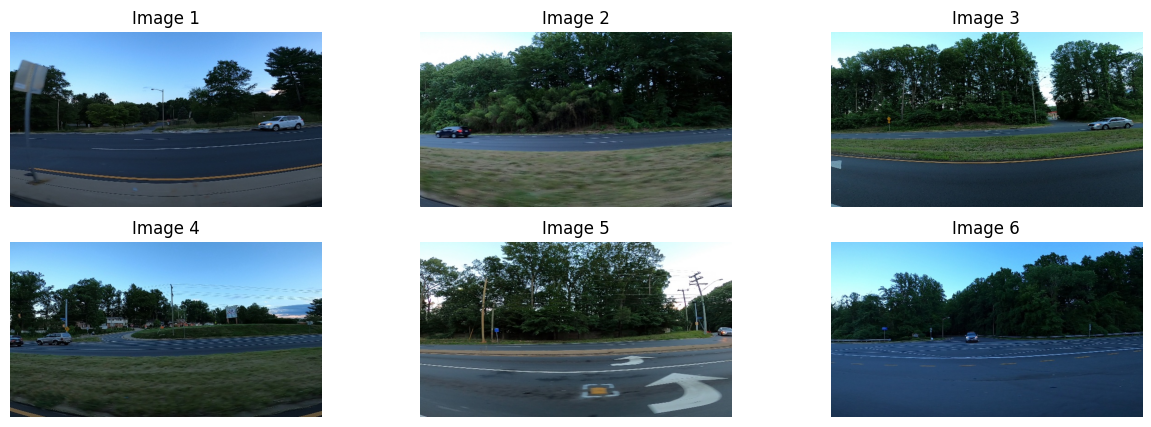

In [13]:
image_paths = train_bounding_boxes['image'].sample(n=6)

# create a matplotlib figure to display the images in a window
fig = plt.figure(figsize=(15, 5))

for i, name in enumerate(image_paths):
    # read the image using cv2
    image = cv2.imread(str(train_path/name))

    # define subplots to display images in a grid
    plt.subplot(2, 3, i + 1)

    # display the image in the current subplot
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(f'Image {i+1}')
    plt.axis('off')

plt.show()

Vizualización del contenido del dataset con las respectivas cajas delimitadoras. The green rectangle represents the correct bounding whereas the red rectangle represents the predicted bounding box.

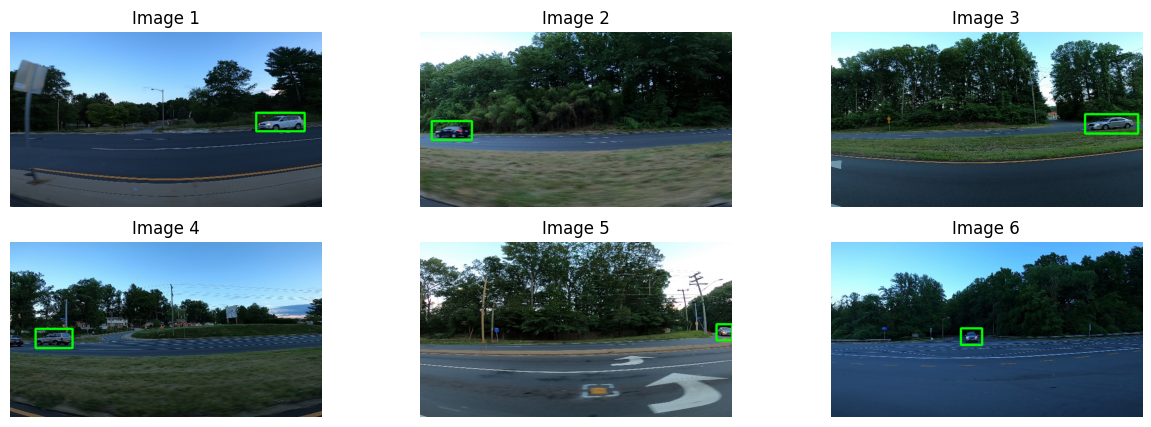

In [14]:
fig = plt.figure(figsize=(15, 5))

for i, name in enumerate(image_paths):
    image = cv2.imread(str(train_path/name))

    # get the coordinates of the bounding boxes of the corresponding image and display over it
    valor = image_paths.index[i]
    fila_objetivo = train_bounding_boxes.iloc[valor]
    xmin = fila_objetivo['xmin']
    ymin = fila_objetivo['ymin']
    xmax = fila_objetivo['xmax']
    ymax = fila_objetivo['ymax']
    img = cv2.rectangle(image, (int(xmin), int(ymin)), (int(xmax), int(ymax)), (0, 255, 0), 3)

    plt.subplot(2, 3, i + 1)

    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(f'Image {i+1}')
    plt.axis('off')

plt.show()

# <font color="#000080B">**4. Modeling**</font>

---

## <font color="#000080B">**4.1. Data Generator**</font>

In keras, all we need to do is initialize some arrays containing images and their corresponding bounding box coordinates. Then, we simply return the newly-created arrays in a dictionary.

The batch size is a hyperparameter that allows you to train models more quickly and effectively, by making more effective use of memory and/or performing parallel learning.

In [8]:
# select 16 images at random and obtain the information about the bounding boxes
def data_generator(df=train_bounding_boxes, batch_size=16, path=train_path):
    while True:
        images = np.zeros((batch_size, 380, 676, 3))
        bounding_box_coords = np.zeros((batch_size, 4))

        for i in range(batch_size):
                rand_index = np.random.randint(0, train_bounding_boxes.shape[0])
                row = df.loc[rand_index, :]
                images[i] = cv2.imread(str(train_path/row.image)) / 255.
                bounding_box_coords[i] = np.array([row.xmin, row.ymin, row.xmax, row.ymax])

        yield {'image': images}, {'coords': bounding_box_coords}


Functions are defined below to visualize the performance of the model graphically.

In [9]:
def test_model(model, datagen):
    example, label = next(datagen)

    X = example['image']
    y = label['coords']

    pred_bbox = model.predict(X)[0]
    img = X[0]

    img *= 255.
    img = img.astype(np.uint8)

    xmin, ymin, xmax, ymax = pred_bbox
    img = cv2.rectangle(img, (int(xmin), int(ymin)), (int(xmax), int(ymax)), (255, 0, 0), 3)
    plt.imshow(img)

    plt.xticks([])
    plt.yticks([])

def test(model):
    datagen = data_generator(batch_size=1)

    plt.figure(figsize=(15,7))
    for i in range(3):
        plt.subplot(1, 3, i + 1)
        test_model(model, datagen)
    plt.show()

class ShowTestImages(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        test(self.model)

## <font color="#000080B">**4.2. Model Building**</font>

The layers that the model will have are defined below. The following types of layers will be used:

Image (InputLayer): This is the input layer of the model. Indicates that images with a shape of (None, 380, 676, 3) are expected, which means that it can handle a variable batch size (None), images that are 380 pixels high, 676 pixels wide, and 3 color channels (RGB).

Convolution Layers (Conv2D): These layers perform convolutions on the input images to extract features. Each layer has a specific number of filters (example: 8, 16, 32, etc.) and uses ReLU activation.

Batch Normalization Layers (BatchNormalization): These layers normalize the activations of the convolution layers. They help stabilize and accelerate training.

Maximum Pooling Layers (MaxPooling2D): These layers perform maximum pooling to reduce the spatial size of the representations.

Flattening Layer: This layer transforms the three-dimensional output of the previous layers into a one-dimensional vector.

Fully Connected Layers (Dense): These layers are densely connected layers where each neuron is connected to all the neurons in the previous layer. The last layer has 4 neurons, therefore the model produces 4 values as output, which are the bounding box coordinates.

In [10]:
# here, the model input is defined. The model expects shape images (380, 676, 3),
# which corresponds to color images with a size of 380 pixels high, 676 pixels wide
#and 3 color channels (red, green and blue).
input_ = Input(shape=[380, 676, 3], name='image')

# a variable x is initialized that will be used to build the architecture of the neural network.
# this information will be stored in the "output" variable
x = input_

# a set of convolution, normalization and pooling layers are performed. In each iteration the number of
# filters to gradually increase the capacity of the neural network
for i in range(10):
    n_filters = 2**(i + 3)
    x = Conv2D(n_filters, 3, activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPool2D(2, padding='same')(x)

# after the convolutional layers, the output is flattened using Flatten. Then they add
# two fully connected layers (Dense) with ReLU activations. The last layer has 4 neurons,
# suggesting that the model is expected to produce 4 values as output (possibly bounding box coordinates).
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dense(32, activation='relu')(x)
output = Dense(4, name='coords')(x)

model = tf.keras.models.Model(input_, output)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image (InputLayer)          [(None, 380, 676, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 380, 676, 8)       224       
                                                                 
 batch_normalization (Batch  (None, 380, 676, 8)       32        
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 190, 338, 8)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 190, 338, 16)      1168      
                                                                 
 batch_normalization_1 (Bat  (None, 190, 338, 16)      64    

Reducing the spatial dimension as you go deeper into the network is done deliberately to achieve a hierarchy of features and to reduce the number of parameters in later layers, which helps control the complexity of the model and prevents overfitting. It also speeds up computation and reduces memory requirements. Increasing channels contributes to the network's ability to understand richer and more abstract features in images.

For each output, we need to specify a loss and a metric. To do this, we simply reference the dictionary key used in the generator and assign it our desired loss function/metric.

In [11]:
model.compile(
    loss={
    # the compilation characteristics are adjusted, the metric used to evaluate is the mean square error
        'coords': 'mse'
    },
    # the Adam optimizer is used, a widely used one
    optimizer=tf.keras.optimizers.Adam(1e-3),
    metrics={
        'coords': 'accuracy'
    }
)

## <font color="#000080B">**5.3. Training and validation**</font>

A model is trained on a GPU for 9 epochs, performing 500 training steps in each epoch and displaying test images using a custom callback. Using a GPU significantly speeds up model training.

Epoch 1/9
1/1 [==============================] - 0s 41ms/step


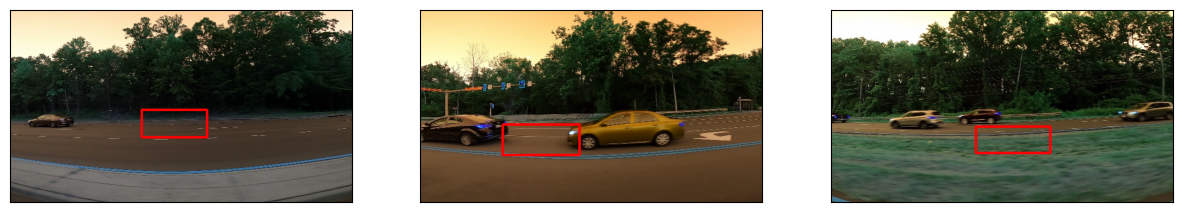

500/500 [==============================] - 288s 532ms/step - loss: 5114.5996 - accuracy: 0.8690
Epoch 2/9
1/1 [==============================] - 0s 51ms/step


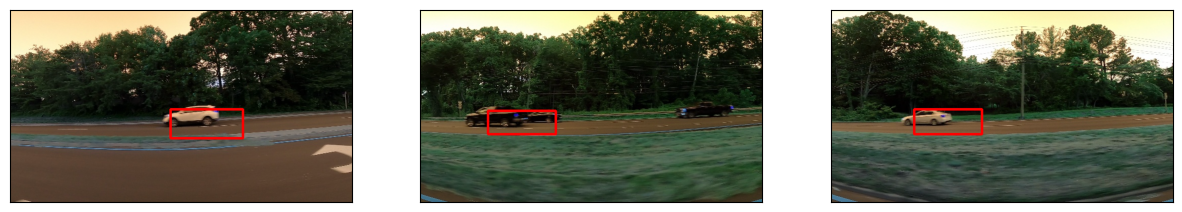

500/500 [==============================] - 151s 302ms/step - loss: 773.5302 - accuracy: 0.9586
Epoch 3/9
1/1 [==============================] - 0s 31ms/step


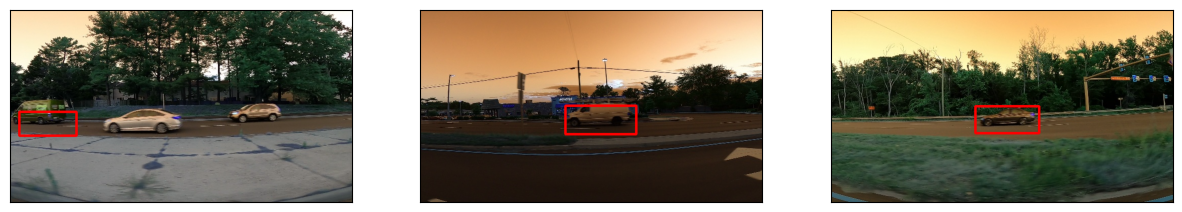

500/500 [==============================] - 158s 317ms/step - loss: 328.5307 - accuracy: 0.9785
Epoch 4/9
1/1 [==============================] - 0s 43ms/step


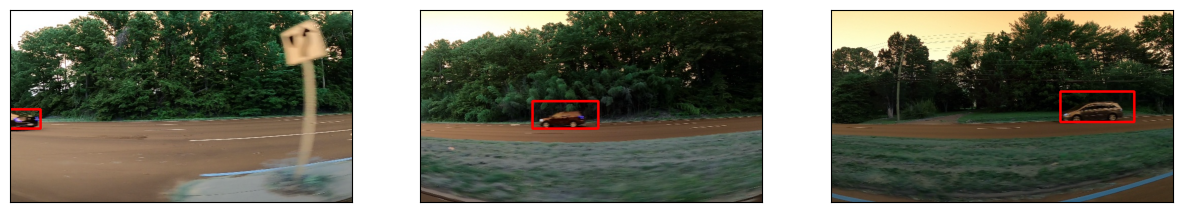

500/500 [==============================] - 166s 333ms/step - loss: 161.7780 - accuracy: 0.9856
Epoch 5/9
1/1 [==============================] - 0s 57ms/step


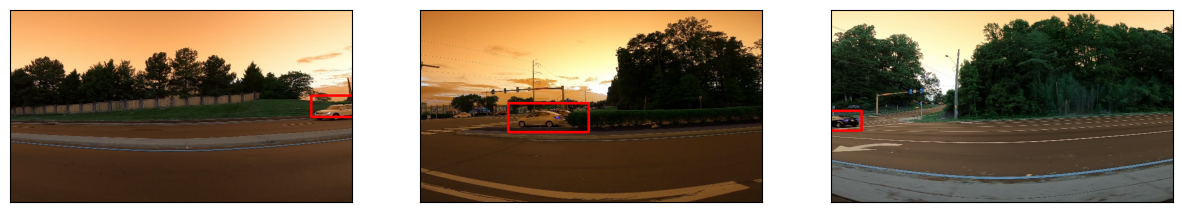

500/500 [==============================] - 154s 309ms/step - loss: 997.8101 - accuracy: 0.9589
Epoch 6/9
1/1 [==============================] - 0s 46ms/step


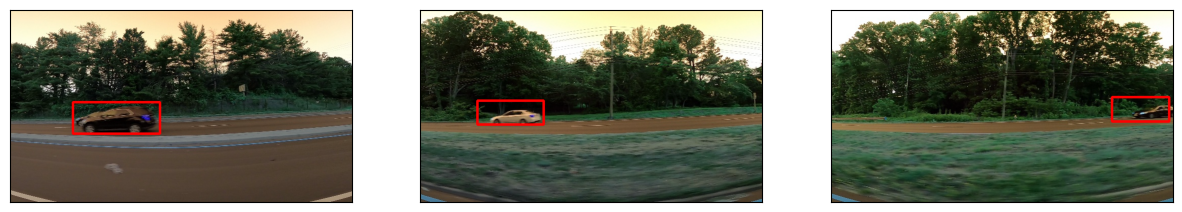

500/500 [==============================] - 156s 312ms/step - loss: 177.9830 - accuracy: 0.9837
Epoch 7/9
1/1 [==============================] - 0s 62ms/step


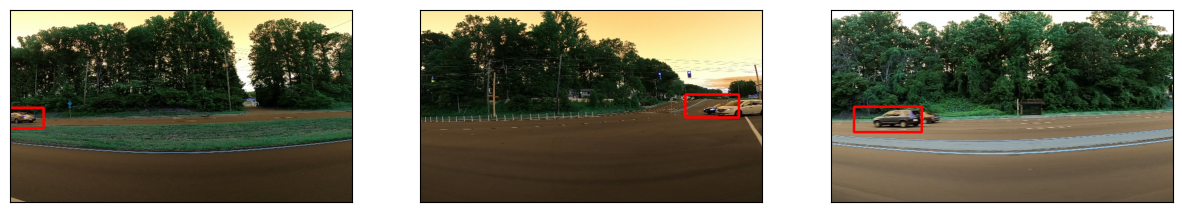

500/500 [==============================] - 158s 316ms/step - loss: 127.8609 - accuracy: 0.9893
Epoch 8/9
1/1 [==============================] - 0s 37ms/step


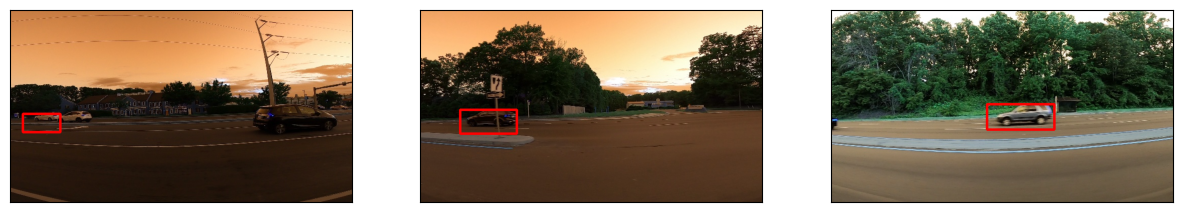

500/500 [==============================] - 161s 323ms/step - loss: 106.1926 - accuracy: 0.9874
Epoch 9/9
1/1 [==============================] - 0s 35ms/step


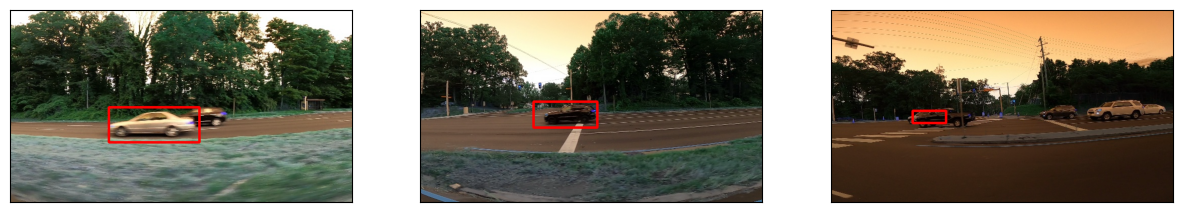

500/500 [==============================] - 156s 313ms/step - loss: 98.9827 - accuracy: 0.9894


In [12]:
with tf.device('/GPU:0'):
    _ = model.fit(
        data_generator(),
        epochs=9,
        steps_per_epoch=500,
        callbacks=[
            ShowTestImages(),
        ]
    )

It is observed that as the epochs are completed the model obtains greater precision. While in the first epoch it is 0.8690, in the ninth it is 0.9894. And this is observed graphically in the bounding boxes.